In [ ]:
from pyrsktools import RSK
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pyrsktools import RSK

# Color definitions
lakecolor = '#ca3e3dff' 
marinecolor = '#46556aff'
lightmarine = '#707c92ff'
background = '#f8f6f4ff'

In [3]:
def read_rbr(filename):
    '''
    Reads data from a .rsk data file from a RBR logger (concerto, solo, ...).
    https://github.com/UNISvalbard/unisacsi/blob/main/unisacsi/Ocean.py#L1488
    Parameters:
    -------
    filename: str
        String with path to file
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''
    
    with RSK(filename) as rsk:
        rsk.readdata()
        rsk.deriveseapressure()
        variables = list(rsk.channelNames)
        time = pd.to_datetime(rsk.data["timestamp"])
        
        if "conductivity" in variables:
            rsk.derivesalinity()
            rsk.derivesigma()
            # variables.append("salinity")
            # variables.append("density")
        variables = list(rsk.channelNames)
        
        data = rsk.data[variables]
        
        df = pd.DataFrame(data, index=time, columns=variables)
        
        #df.rename({"condictivity": "C", "temperature": "T", "salinity": "S", "pressure": "P", "sea_pressure": "Ps", "density_anomaly": "SIGTH"}, axis=1, inplace=True)
        df.sort_index(axis=0, inplace=True)
        
    return df

In [ ]:
directory = r"...path"

file_list = sorted([os.path.join(directory, x)
                                for x in os.listdir(directory)
                                if x.endswith('rsk')
                                and not x.startswith('.')])
# Print number of files found
print(f"Found {len(file_list)} CTD measurements")

Found 3 CTD measurements


In [5]:
dataframes = [read_rbr(file) for file in file_list]

for i in range(len(dataframes)):
    df = dataframes[i]
    df = df[df['depth'] >= 0.2]
    df = df[df.index < df['depth'].idxmax()]
    cutoff = df['depth'].max() - 0.5
    dataframes[i] = df[df['depth'] <= cutoff]


# Create a dictionary of CTD names
CTDs = {f'CTD{i+1}': df for i, df in enumerate(dataframes)}

In [6]:
print(f"{'CTD':<10} {'MaxDepth':>10} {'MeanTemp':>12} {'MaxTemp':>10} {'MinTemp':>10} {'Diff':>10}")
for CTD in CTDs:
    depth_max = CTDs[CTD]['depth'].max()
    temp_mean = CTDs[CTD]['temperature'].mean()
    temp_max = CTDs[CTD]['temperature'].max()
    temp_min = CTDs[CTD]['temperature'].min()
    temp_diff = temp_max - temp_min

    print(f"{CTD:<10} {depth_max:>10.2f} {temp_mean:>12.4f} {temp_max:>10.4f} {temp_min:>10.3f} {temp_diff:>10.3f}")


CTD          MaxDepth     MeanTemp    MaxTemp    MinTemp       Diff
CTD1           306.99       0.6547     0.7354      0.464      0.272
CTD2           260.44       0.6752     0.7249      0.608      0.117
CTD3           168.99       0.7054     0.8566      0.614      0.242


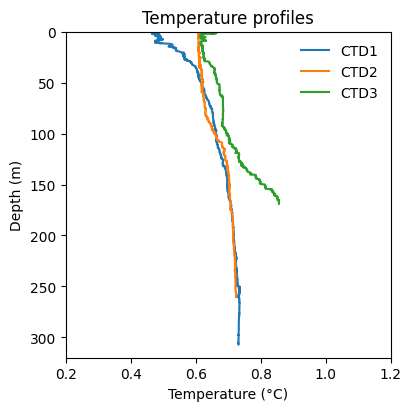

In [7]:
fig, ax = plt.subplots( figsize=(4, 4), layout='constrained')

for ctd_name in CTDs:
    df = CTDs[ctd_name]
    ax.plot(df['temperature'], df['depth'], label=ctd_name)

ax.set_xlim(0.2, 1.2)
ax.set_ylim(0, 320)
ax.invert_yaxis()  # Invert y-axis to have depth increasing downwards
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Depth (m)')
ax.set_title('Temperature profiles')
ax.legend(frameon = False)

#plt.savefig(r"path.pdf", bbox_inches='tight')
plt.show()
